# IRISreader Tutorial Notebook

<img src="irisreader.png" width="130" align="left" style="margin-right: 50px"> 

This notebook explores the functionality of [IRISreader](https://github.com/i4Ds/IRISreader). 

If you have not installed IRISreader yet, please follow the installation guide in the [README](https://github.com/i4Ds/IRISreader/blob/master/README.md).
IRISreader relies heavily on *numpy*. If you are not yet familiar with numpy, please read the following [quickstart tutorial](https://docs.scipy.org/doc/numpy-1.13.0/user/quickstart.html). To install Jupyter to access the notebook, please read their [installation instructions](http://jupyter.org/install). If you have any comments, feel free to drop me a [note](mailto:cedric.huwyler@fhnw.ch).



In the notebook we will use the following libraries in addition to IRISreader:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Part 1: Configuration

Let us first make sure that irisreader is properly configured:

In [2]:
import irisreader as ir
ir.config

IRISreader configuration:
---------------------------
default_mirror: lmsal
goes_base_url: http://server1071.cs.technik.fhnw.ch/iris/goes/xrs/
hek_base_url: http://www.lmsal.com/hek/her
max_open_files: 256
mirrors: {'lmsal': 'http://www.lmsal.com/solarsoft/irisa/data/level2_compressed/', 'uio': 'http://sdc.uio.no/vol/fits/iris/level2/', 'fhnw': 'http://server0090.cs.technik.fhnw.ch/iris_compressed/'}
use_memmap: False
verbosity_level: 1

We keep `verbosity_level = 1` for interactive mode. If you are inside the FHNW network, comment out the next command and change the default data mirror to 'fhnw' (makes things much faster). Otherwise just leave it and download from LMSAL. If you already have some downloaded data on your harddrive, feel free to omit the download step and replace the observation directory path in `obs = observation( .. )`.

In [3]:
ir.config.default_mirror="fhnw"

## Part 2: Data Access

### 1.1 The OBS interface

The OBS interface provides structured access to IRIS observation data. Such data usually come as a directory with several slit-jaw image (SJI) and spectrograph (raster) FITS files. In the following we will download an observation from [LMSAL](http://iris.lmsal.com/search/):

In [4]:
# Note: In this notebook we will download some data, if you prefer to work in another directory than the current one,
# please change the path:
import os
os.chdir( "." )

In [ ]:
from irisreader.utils import download
download( "20140910_112825_3860259453", target_directory="." )

The download function would have actually already opened the observation for you. Let us however do this on our own for educational purposes this time:

In [6]:
from irisreader import observation
obs = observation( "20140910_112825_3860259453" )

Let us check the different attributes of this observation. The most basic information can be found by simply printing out the observation object:

In [7]:
print( obs )

Large sit-and-stare 0.3x120 1s  Si IV   Mg II h/k Deep x 8  FUV spec
2014-09-10 11:28:25 - 2014-09-10 17:58:08

SJI lines:
  field  wavelength     description
0  FUV2      1400.0      Si IV 1400
1   NUV      2796.0  Mg II h/k 2796

raster lines:
  field  wavelength   description
0  FUV1      1335.7     C II 1336
1  FUV1      1343.3          1343
2  FUV1      1349.4   Fe XII 1349
3  FUV1      1355.6      O I 1356
4  FUV2      1402.8    Si IV 1403
5   NUV      2832.8          2832
6   NUV      2826.7          2826
7   NUV      2814.5          2814
8   NUV      2796.2  Mg II k 2796


Here are a few more attributes:

In [8]:
obs.obsid

'3860259453'

In [9]:
obs.mode

'sit-and-stare'

In [10]:
[obs.start_date, obs.end_date]

['2014-09-10T11:28:25.590', '2014-09-10T17:58:08.380']

The SJI and raster data cubes can be accessed through the `sji` and `raster` loaders:

#### SJI:

In [11]:
obs.sji.get_lines()

,field,wavelength,description
0,FUV2,1400.0,Si IV 1400
1,NUV,2796.0,Mg II h/k 2796


In [12]:
obs.n_sji

2

The individual SJI lines can be accessed either by accessing the loader with an index or by calling the loader with a search string that uniquely identifies the line:

In [13]:
obs.sji[0].line_info

'Si IV 1400'

In [14]:
obs.sji[1].line_info

'Mg II h/k 2796'

In [15]:
obs.sji("Si").line_info

'Si IV 1400'

In [16]:
obs.sji("Mg II h/k").line_info

'Mg II h/k 2796'

Notice the warning. Here there are in general two different type of Magnesium windows (the other one is the Mg II wing). The search string is clear in this case, but it will not be if you search through a large corpus of observations.

#### Raster:

In [17]:
obs.n_raster

1

There is only 1 raster file present. For n-step rasters, where the camera sweeps $n$ times over the same region, there will be $n$ files in the observation. As we will see below, IRISreader abstracts all the individual raster files as one.

In [18]:
obs.raster.get_lines()

,field,wavelength,description
0,FUV1,1335.7,C II 1336
1,FUV1,1343.3,1343
2,FUV1,1349.4,Fe XII 1349
3,FUV1,1355.6,O I 1356
4,FUV2,1402.8,Si IV 1403
5,NUV,2832.8,2832
6,NUV,2826.7,2826
7,NUV,2814.5,2814
8,NUV,2796.2,Mg II k 2796


Similar to the SJI, the raster lines can be access through an index and a search string interface:

In [19]:
obs.raster("Mg II k").line_info

'Mg II k 2796'

In [20]:
obs.raster[4].line_info

'Si IV 1403'

### 1.2: Data Cube and Header Access

Data cubes and headers can be accessed through the loaders `sji` and `raster`. IRISreader uses a lazy loading approach, loading data and headers only once they are requested. 

### Headers

Let us start with header access. Each line contains the data cube stored in the FITS extension and primary and time-specific (and for rasters even line-specific headers). All the headers belonging to a line can be simply accessed with `headers[<time step>][<header key>]`. If you want to access only the primary headers, time-specific headers or line-specific headers, you can access them through `primary_headers[<header key>]`, `time_specific_headers[<time step>]` and `line_specific_headers[<header key>]` respectively.

Notice how it takes longer to access the header the first time, because IRIS loads the headers only upon your first request:

In [21]:
%time obs.sji("Si").headers[0]['SAT_ROT']

CPU times: user 49.6 ms, sys: 4.72 ms, total: 54.3 ms
Wall time: 52.7 ms


2.10064e-05

In [22]:
%time obs.sji("Si").headers[0]['DATE_OBS']

CPU times: user 471 µs, sys: 0 ns, total: 471 µs
Wall time: 444 µs


'2014-09-10T11:28:25.690'

In [23]:
obs.sji("Si").primary_headers['HISTORY']

iris_prep  Set 1 saturated pixels to Inf
iris_prep  Dark v20130925; T=[-65.0,-64.2,-64.0,-65.0,-0.0,0.2,0.2,0.2,1
iris_prep  Flat fielded with recnum     150
iris_prep  Set permanently bad pixels to 0 prior to warping
iris_prep_geowave_roi  ran with rec_num 4
iris_prep_geowave_roi  boxwarp set to 1
iris_prep_geowave_roi  updated WCS parameters with iris_isp2wcs
iris_prep  Used iris_mk_pointdb ver 10
iris_prep       Fiducial midpoint shift X,Y [pix]:     13.82     4.82
iris_prep  Used INF_POLY_2D for warping
iris_prep VERSION:  1.83
iris_prep   ran on 20170616_030825
level2  Version L12-2017-04-23

In [24]:
obs.sji("Si").time_specific_headers[10]['XCENIX']

-167.4004266603198

In [25]:
obs.raster("Mg II k").headers[0]['ENDOBS']

'2014-09-10T17:58:08.380'

In [26]:
obs.raster("Mg II k").line_specific_headers['WAVENAME']

'Mg II k 2796'

(similarly, `primary_headers` and `time_specific_headers` can be accessed for rasters)

### Data

IRISreader uses `astropy.fits` to open FITS files, which relies on memory mapping, i.e. files are read directly from the hard drive instead of loading them into RAM. Of course as soon as the data is processed, it has to be loaded into memory.
Data access can be done in two different ways, depending on the access type:

**1. Time slices (images)**

Most of the time, one will want to access single images at a time and perform some computations on them. Then it's most efficient to load the images into memory only upon request. This can be done with the `get_image_step` functionality:

In [27]:
obs.sji("Si").get_image_step(10)

array([[-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.],
       ...,
       [-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.]], dtype=float32)

We can plot this image with matplotlib:

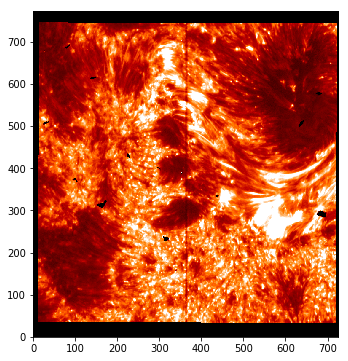

In [28]:
plt.imshow( obs.sji("Si").get_image_step(10).clip(min=0)**0.4, origin="lower", cmap="gist_heat", vmax=10 )
plt.show()

Here we applied a gamma correction of 0.4 to make the image look nice and cut it off at a good intensity. Also, we set all negative pixel values to zero with `clip`. The `plot` function can do this directly: (note that we can control the size of the figure in the notebook with `plt.figure(figsize=(x,y))`)

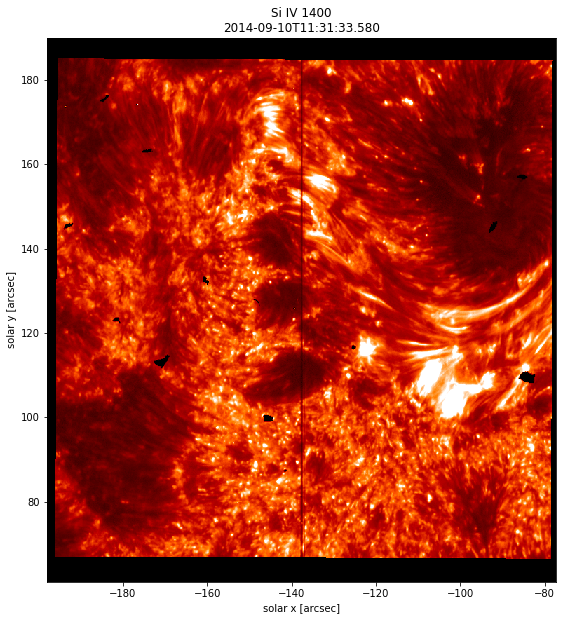

In [29]:
plt.figure( figsize=(10,10))
obs.sji("Si").plot( 10, units="coordinates", cutoff_percentile=99 )

where we used coordinates on the Sun instead of CCD pixels. This function automatically applies a gamma correction of 0.4, you can manually set it through the argument `gamma`.

**2. Arbitrary slices**

If the user desires a specific slice of the data, it is often more efficient if the data is loaded into memory first. The slices can then be accessed through an index. We show this for a raster, but the access is similar for SJI. The slice access follows the format *[ time step, y pixel, wavelength pixel ]*, where the wavelength pixel number can be replaced with the x pixel number for SJI. Notice the convention here that $y$ comes before $x$.

In the following we want to create a two-dimensional plot that shows the evolution of a fixed wavelength along the y-axis over time:

In [30]:
mg_slice = obs.raster("Mg II k")[:,:,100].clip(min=0)

In [31]:
mg_slice.shape

(2487, 776)

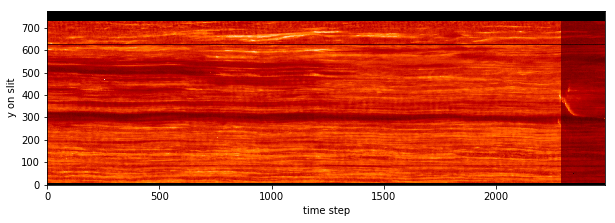

In [32]:
plt.figure( figsize=(10,5) )
plt.xlabel( "time step" )
plt.ylabel( "y on slit" )
plt.imshow( np.transpose(mg_slice)**0.4, cmap="gist_heat", vmax=10 )
plt.show()

This looks already nice! We used a gamma correction of 0.4 to see more structure in the image. However notice the dark region at the right end. Because a flare occured there, IRIS had to reducethe exposure time. Thus the previous 'quiet' part of the image looks now much darker. We can get rid of this by dividing through exposure time:

In [33]:
exposures = [h['EXPTIME'] for h in obs.raster("Mg II k").headers]

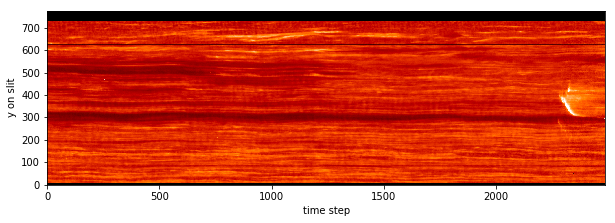

In [34]:
plt.figure( figsize=(10,5) )
plt.xlabel( "time step" )
plt.ylabel( "y on slit" )
plt.imshow( (np.transpose(mg_slice) / exposures)**0.4, cmap="gist_heat", vmax=4.5 )
plt.show()

This concludes the data access part. Let us close the observation and all open file handles that are tied to it:

In [35]:
obs.close()

## Part 2: Basic Preprocessing

IRISreader offers some basic preprocessing functionalities that help making the data ready for machine learning tasks. In the following, we will look at image cropping and spectrum interpolation:

### 2.1 Image Cropping

Did you notice the black borders in the images above? They are here because in IRIS level 1 data there is some misalignment in the CCD images; to correct for this misalignment, the images are rotated into the right position during level 2 processing. However, this rotation leaves some artefacts in the form of regions where all pixels are set to -200 (which we call NULL here) which the plot function displays as black. Notice that also black regions due to dust particles on the camera have negative pixel values.

IRISreader comes with a cropping algorithm, that makes a choice in cropping out the non-negative part of the image. While an astronomer will probably prefer to keep as much information in the image as possible, for big data processing tasks we rather lose some data but are then sure that the data comes in a good format without artefacts. The IRISreader cropping algorithm works by sending a line from each frame border towards the image center, counting the number of non-negative pixels along the line. Once the number of non-negative pixels stops increasing, it stops moving the line towards the center. Once this is done for all four sides, we have defined a frame that contains no negative pixels (or at least only a few from dust and some other image corruptions - images with more than 5% negative pixels after cropping are automatically discarded as being corrupt by the algorithm). Here is a sketch of how the cropping algorithm works:

<img src="cropping_algorithm.png" width="700">

You can find the implementation of the algorithm in `irisreader.preprocessing.image_cropper` and an application of this algorithm to image cubes (finds the best boundary for all images in a cube) in `irisreader.preprocessing.image_cube_cropper`. However, you do not need to take care of this classes, everything is already done for you in the `crop` method of the sji and raster classes:

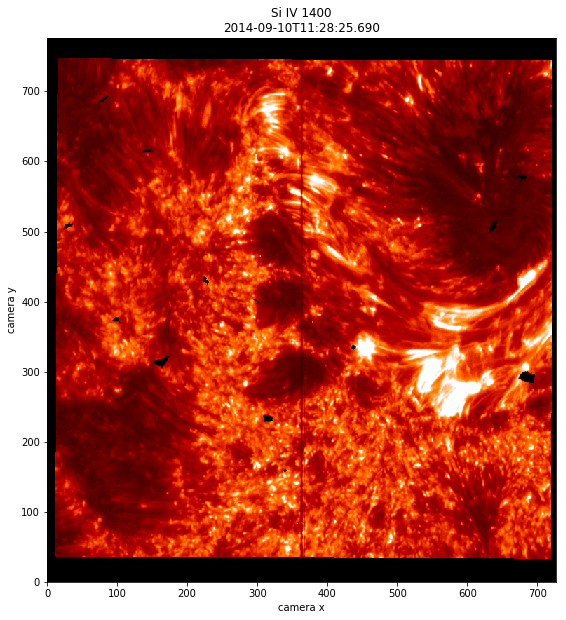

In [36]:
obs = observation( "20140910_112825_3860259453" )
plt.figure( figsize=(10,10))
obs.sji("Si").plot( 0, cutoff_percentile=99 )

In [37]:
obs.sji("Si").crop()

100%|██████████| 1245/1245 [00:02<00:00, 527.35it/s]


Notice that you can avoid the progress bar via `ir.config.verbosity_level=0`

Let us now plot the first image of the cropped data cube:

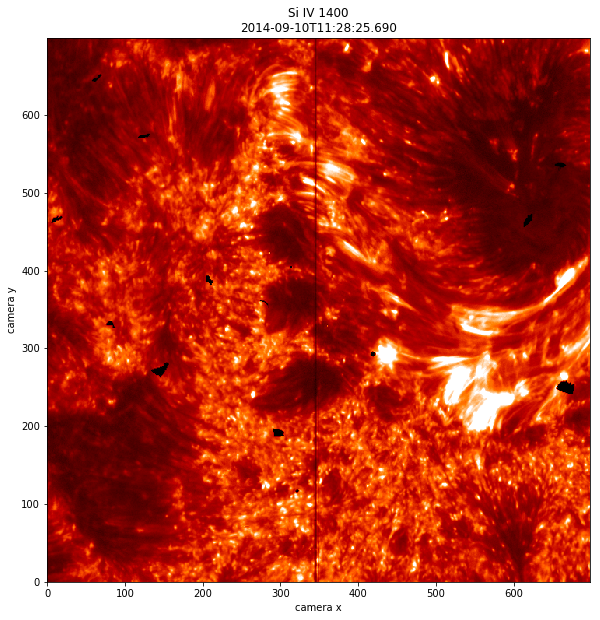

In [38]:
plt.figure( figsize=(10,10))
obs.sji("Si").plot(0, cutoff_percentile=99)

This looks nice! Only a few pixels on the sides are lost. In general, this algorithm works very well. We can also do this for a raster:

100%|██████████| 2487/2487 [00:08<00:00, 277.41it/s]


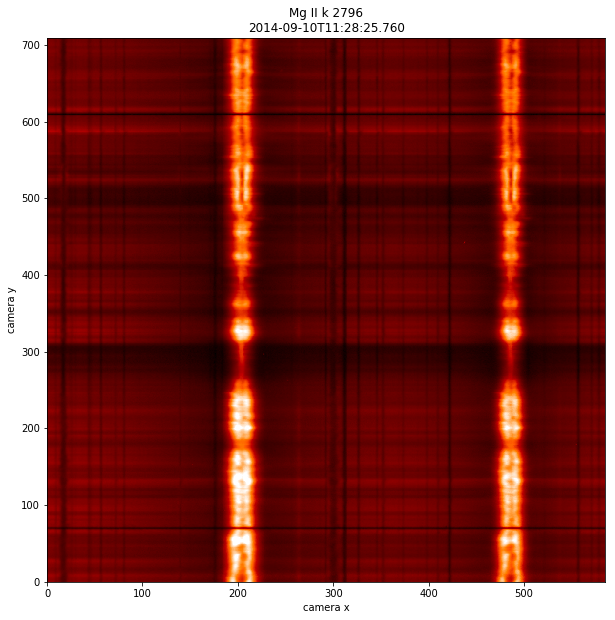

In [39]:
obs.raster("Mg II k").crop()
plt.figure( figsize=(10,10))
obs.raster("Mg II k").plot( 0 )

There is also an option in the `plot` function to plot only one spectrum on a pixel of the y-axis:

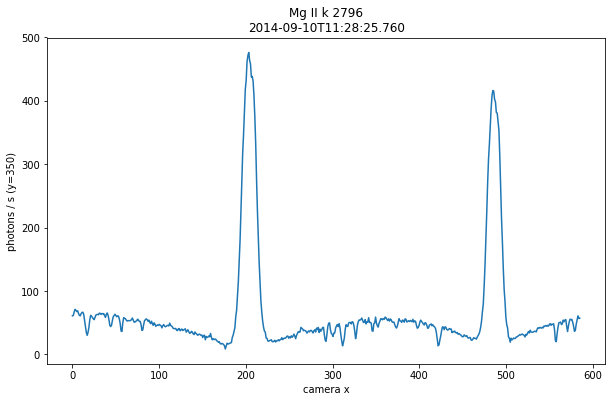

In [40]:
obs.raster("Mg II k").plot( 0, y=350 )

### 2.2 Spectrum interpolation

Say we want to read spectra from many different observations and perform a machine learning task on this data. The spectra come in many different resolutions (as the data downlink is limited and expensive, sometimes more line windows with a worse resolution are preferred over only a few line windows with a good resolution).

IRISreader has a function ready that interpolates all the spectra to a common interval, look at the following example:

In [41]:
lambda_min = 2794
lambda_max = 2800
n_breaks = 100
interpolated_image = obs.raster("Mg II k").get_interpolated_image_step( 0, lambda_min, lambda_max, n_breaks=100 )

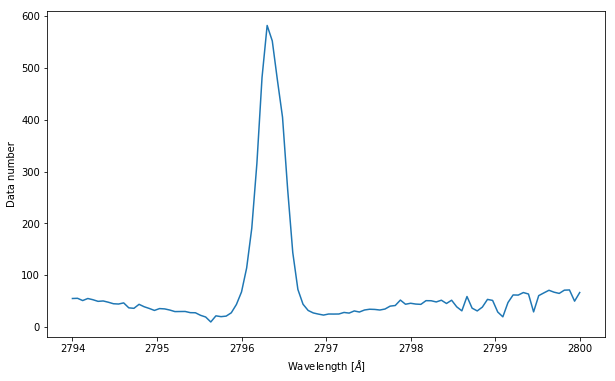

In [42]:
plt.xlabel( r'Wavelength [$\AA$]' )
plt.ylabel( "Data number" )
plt.plot( np.linspace( lambda_min, lambda_max, n_breaks ), interpolated_image[400] )
plt.show()

The algorithm has cut out only the region between $\lambda_\text{min} = 2794 \, Å$ and $\lambda_\text{min} = 2800  \, Å$ and has interpolated the spectrum to 100 steps.

## Part 3: Browsing Observations

Iterating through large sets of observations is a very basic need if one wants to treat IRIS data as a big data problem. In the following you will learn how to do this in a very simple way with the `obs_iterator` class. Unfortunately, you might not have a larger corpus of observations available. If you want to download a few ones with flares in it, use the code below to download them (will probably take 1-2 hours). Otherwise feel free to just read through the next part and acknowledge the possibilities that you have with `obs_iterator`.

In [ ]:
download( "20140329_140938_3860258481", target_directory=".", open_obs=False )

In [ ]:
download( "20140331_024530_3860613353", target_directory=".", open_obs=False )

In [ ]:
download( "20140906_112339_3820259253", target_directory=".", open_obs=False )

In [ ]:
download( "20140418_123338_3820259153", target_directory=".", open_obs=False )

Now let us create an iterator and print out the description of each observation:

In [47]:
from irisreader import obs_iterator
for obs in obs_iterator("."):
    print( '{}: {}'.format( obs.obsid, obs.desc) )

Reading directories [this can take a while].. 
done [5 directories]
3860258481: Very large coarse 8-step raster 14x175 8s  Si IV   Mg II h/k   Mg II
3860613353: Large sit-and-stare 0.3x120 1s  C II   Mg II h/k Deep x 30 Spatial x
3820259153: Large sit-and-stare 0.3x120 1s  C II   Si IV   Mg II h/k Deep x 8  F
3820259253: Large sit-and-stare 0.3x120 1s  C II   Si IV Deep x 8  FUV spectrall
3860259453: Large sit-and-stare 0.3x120 1s  Si IV   Mg II h/k Deep x 8  FUV spec


This is easy! `obs_iterator` finds all directories that are IRIS observations and makes them iterable. We can also plot the first image of each Si IV slit-jaw image as a quicklook:

Reading directories [this can take a while].. 
done [5 directories]


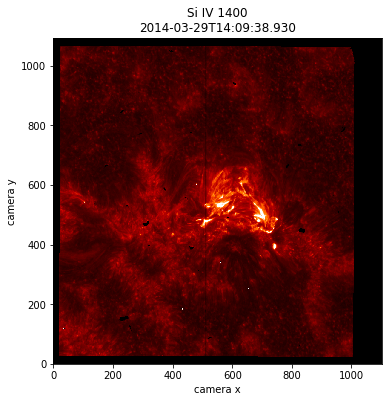

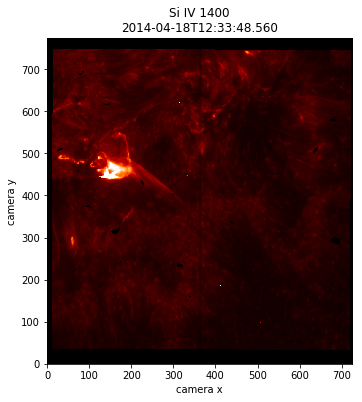

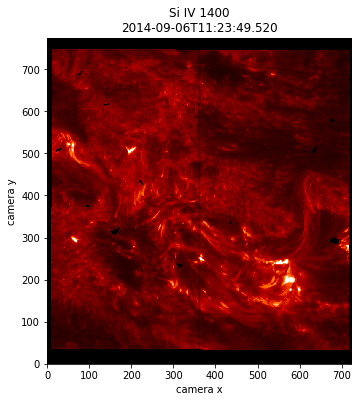

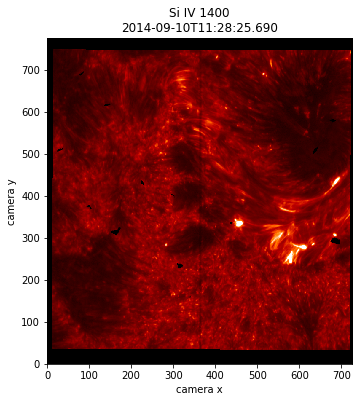

In [48]:
for obs in obs_iterator("."):
    if obs.sji.has_line("Si IV"):
        obs.sji("Si IV").plot(0)
        plt.show()

## Part 4: GOES X-ray Flux and HEK Coalignment

IRISreader can download GOES15 XRS files and make them available for the observation class. Let us open our first observation once more:

In [49]:
obs = observation( "20140910_112825_3860259453" )

We can get a data frame with the associated GOES15 XRS data:

In [50]:
obs.goes.data

,A_QUAL_FLAG,A_COUNT,A_FLUX,B_QUAL_FLAG,B_COUNT,B_FLUX
time_tag,,,,,,
2014-09-09 00:00:01.980,0,64551.0,6.507300e-06,0,91823.0,2.430600e-05
2014-09-09 00:00:04.030,0,64567.0,6.509500e-06,0,91919.0,2.433700e-05
2014-09-09 00:00:06.077,0,64711.0,6.529600e-06,0,92111.0,2.440000e-05
2014-09-09 00:00:08.127,0,64759.0,6.536200e-06,0,92207.0,2.443100e-05
2014-09-09 00:00:10.173,0,64839.0,6.547400e-06,0,92335.0,2.447300e-05
2014-09-09 00:00:12.220,0,64935.0,6.560800e-06,0,92495.0,2.452600e-05
2014-09-09 00:00:14.270,0,64999.0,6.569700e-06,0,92591.0,2.455700e-05
2014-09-09 00:00:16.317,0,65079.0,6.580800e-06,0,92687.0,2.458900e-05
2014-09-09 00:00:18.367,0,65095.0,6.583000e-06,0,92847.0,2.464100e-05


IRISreader will automatically download the necessary files and store them in the observation directory. GOES data is available from https://satdat.ngdc.noaa.gov/sem/goes/data/full/, however IRISreader uses a mirror at FHNW that is faster:

In [51]:
ir.config.goes_base_url

'http://server1071.cs.technik.fhnw.ch/iris/goes/xrs/'

If you are inside the FHNW network it is faster and safer (the NOAA server will e.g. be down during US government shutdowns that seem to be very common and long nowadays...) to use

It is also possible to plot the GOES X-ray flux around and during the observation:

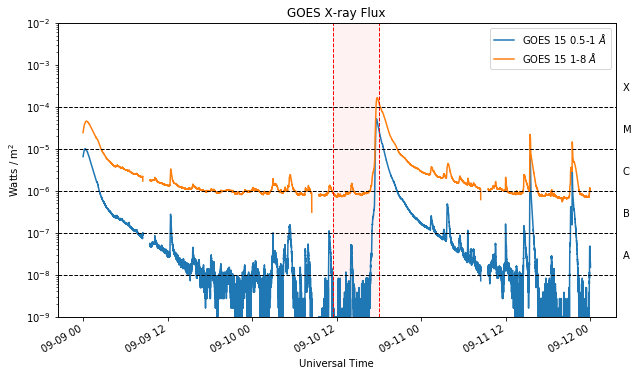

In [52]:
obs.goes.plot()

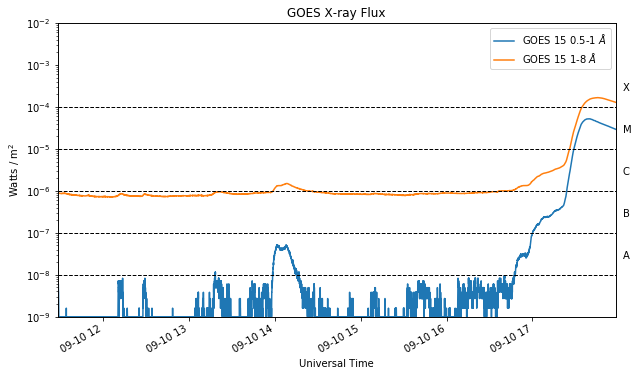

In [53]:
obs.goes.plot( restrict_to_obstime=True )

There is obviously an X-Flare taking place during this observation! Let's hope the IRIS pointed to this flare.. To that end there is a function that interpolates GOES X-ray flux (1-8 Å) to the timestamps of the pictures IRIS took:

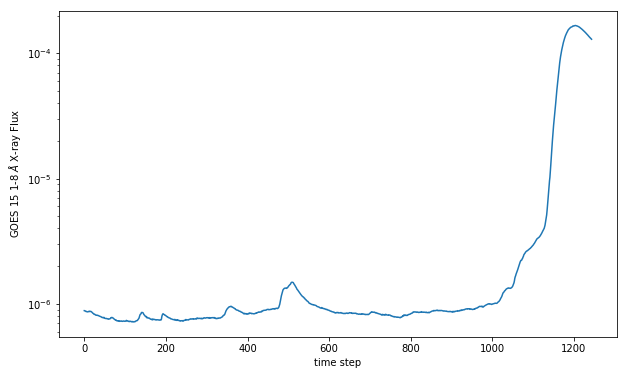

In [54]:
goes_flux = obs.sji("Mg II h/k").get_goes_flux()
plt.xlabel("time step")
plt.ylabel(r"GOES 15 1-8 $\AA$ X-ray Flux")
plt.semilogy( goes_flux )
plt.show()

This allows us to get the image where the GOES flux was highest:

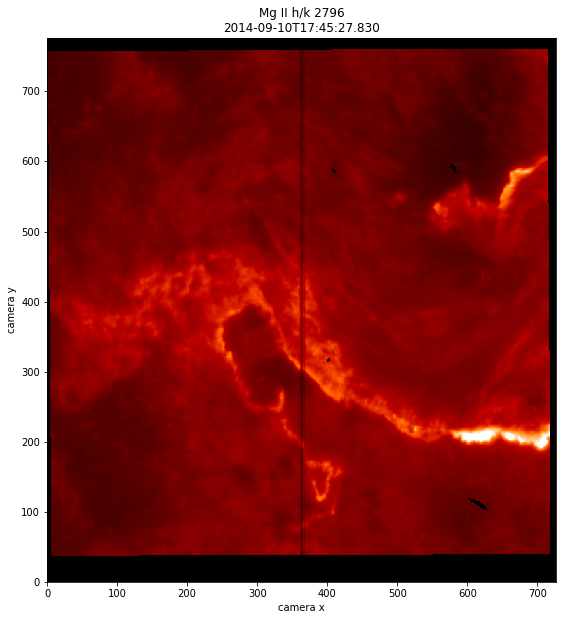

In [55]:
plt.figure( figsize=(10,10))
obs.sji("Mg II h/k").plot( np.argmax( goes_flux ) )

It is also possible to access <a href="http://www.lmsal.com/heksearch/">Heliophysics Events Knowledgebase</a> events that took place around the time of the observation:

In [56]:
obs.hek.data

,ar_noaaclass,ar_noaanum,event_endtime,event_peaktime,event_starttime,event_type,fl_goescls,fl_peakflux,frm_daterun,frm_name,...,hpc_radius,hpc_x,hpc_y,intensmax,intensmedian,intensmin,kb_archivdate,obs_channelid,obs_meanwavel,obs_observatory
0,,12159,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:48,NOAA SWPC Observer,...,555.925701981442899,-334.281600,-444.195000,None,None,None,2014-09-10T02:33:59,visible,5.000000e-05,various
1,,12155,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:44,NOAA SWPC Observer,...,468.200337013120873,124.225200,-451.419600,None,None,None,2014-09-10T02:33:55,visible,5.000000e-05,various
2,,12157,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:46,NOAA SWPC Observer,...,349.822129637137721,-48.565320,-346.434600,None,None,None,2014-09-10T02:33:57,visible,5.000000e-05,various
3,,12161,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:49,NOAA SWPC Observer,...,768.906594314914173,712.716000,-288.536400,None,None,None,2014-09-10T02:34:00,visible,5.000000e-05,various
4,,12162,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:50,NOAA SWPC Observer,...,704.476567384011673,701.130000,68.585400,None,None,None,2014-09-10T02:34:02,visible,5.000000e-05,various
5,,12163,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:52,NOAA SWPC Observer,...,662.301746165718669,-549.867000,-369.174600,None,None,None,2014-09-10T02:34:03,visible,5.000000e-05,various
6,,12158,2014-09-10T23:59:59,NaN,2014-09-10T00:00:00,AR,NaN,NaN,2014-09-10T02:35:47,NOAA SWPC Observer,...,259.823510052650931,-223.513800,132.475800,None,None,None,2014-09-10T02:33:58,visible,5.000000e-05,various
8,,2158,2014-09-10T14:22:00,2014-09-10T14:08:00,2014-09-10T13:57:00,FL,C1.5,NaN,2014-09-11T00:00:00,SSW Latest Events,...,138.948434784275264,-80.910600,112.960800,None,None,None,2014-09-10T23:59:13,EUV,1.310000e-06,SDO
9,,2158,2014-09-10T17:45:00,2014-09-10T17:45:00,2014-09-10T17:21:00,FL,X1.6,NaN,2014-09-10T00:00:00,SSW Latest Events,...,103.356896418307869,-81.860172,63.099606,None,None,None,2017-08-31T19:45:12,EUV,1.310000e-06,SDO
10,,12158,2014-09-10T18:20:00,2014-09-10T17:45:00,2014-09-10T17:21:00,FL,X1.6,NaN,2014-09-10T00:00:00,SWPC,...,117.170788732216025,-32.400360,112.602000,None,None,None,2014-09-11T05:33:33,XRA,5.000000e-08,GOES


There were three flares! Let's filter them out and investigate them more closely:

In [57]:
flare_df = obs.hek.data[ obs.hek.data.event_type=='FL' ]
flare_df[['event_endtime','event_peaktime','event_starttime','fl_goescls','hpc_x', 'hpc_y']]

,event_endtime,event_peaktime,event_starttime,fl_goescls,hpc_x,hpc_y
8,2014-09-10T14:22:00,2014-09-10T14:08:00,2014-09-10T13:57:00,C1.5,-80.910600,112.960800
9,2014-09-10T17:45:00,2014-09-10T17:45:00,2014-09-10T17:21:00,X1.6,-81.860172,63.099606
10,2014-09-10T18:20:00,2014-09-10T17:45:00,2014-09-10T17:21:00,X1.6,-32.400360,112.602000


Are these our flares? **hpc_x** and **hpc_y** are the world coordinates on the sun given by HEK, let's check whether IRIS' field of view is in the same region. To this end we use the `pix2coords` function of `sji_cube` to get the coordinates of the field of view corners:

In [58]:
sji = obs.sji[0]
xmin, ymin = sji.pix2coords(pixel_coordinates=[0,0], step=0)
xmax, ymax = sji.pix2coords(pixel_coordinates=[sji.shape[1],sji.shape[0]], step=0)
print("xmin = {}, xmax = {}, ymin = {}, ymax = {}".format(xmin, xmax, ymin, ymax))

xmin = -197.9679772465921, xmax = -66.5448185637849, ymin = 60.992128912092106, ymax = 266.6415445195362


xmin $\leq$ hpc_x $\leq$ xmax and ymin $\leq$ hpc_y $\leq$ ymax for two of the three events. Please notice that as solar flares have a certain extension, a single HEK coordinate pair is not an accurate measure of the flare location.

Finally, let's close the observation:

In [59]:
obs.close()

## Part 5: The tools behind the OBS interface

Now you have already seen a great deal of what you can do with the OBS interface. This chapter is some optional reading, going a bit deeper into how the OBS interface is built up.

The foundation of IRISreader is the `iris_data_cube` class. This class opens a FITS file with IRIS data and reads the headers and the data in the extensions:

In [60]:
from irisreader import iris_data_cube
fits_data = iris_data_cube("20140910_112825_3860259453/iris_l2_20140910_112825_3860259453_SJI_1400_t000.fits")

In [61]:
fits_data.get_image_step( 0 )

array([[-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.],
       ...,
       [-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.],
       [-200., -200., -200., ..., -200., -200., -200.]], dtype=float32)

The `iris_data_cube` class tries to give as much functionality as possible without taking into account the particularities of SJIs and rasters. The `sji_cube` and `raster_cube` classes inherit from `iris_data_cube` and implement SJI and raster-specific functionality on top of it (so if you're not trying to hack something, you should never use `iris_data_cube`):

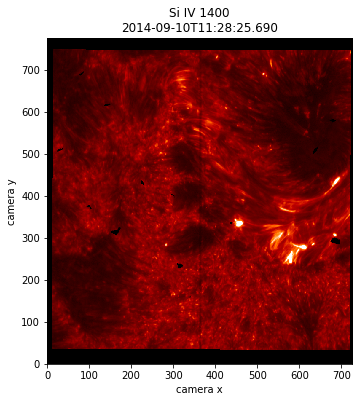

In [62]:
from irisreader import sji_cube
sji = sji_cube("20140910_112825_3860259453/iris_l2_20140910_112825_3860259453_SJI_1400_t000.fits")
sji.plot(0)

In [63]:
from irisreader import get_lines
get_lines("20140910_112825_3860259453/iris_l2_20140910_112825_3860259453_raster_t000_r00000.fits")

,field,wavelength,description
0,FUV1,1335.7,C II 1336
1,FUV1,1343.3,1343
2,FUV1,1349.4,Fe XII 1349
3,FUV1,1355.6,O I 1356
4,FUV2,1402.8,Si IV 1403
5,NUV,2832.8,2832
6,NUV,2826.7,2826
7,NUV,2814.5,2814
8,NUV,2796.2,Mg II k 2796


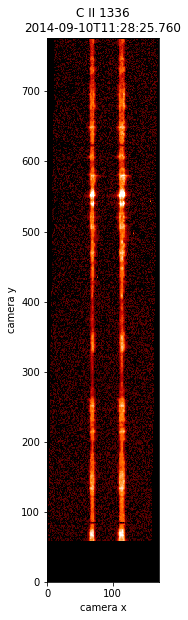

In [64]:
from irisreader import raster_cube
raster = raster_cube("20140910_112825_3860259453/iris_l2_20140910_112825_3860259453_raster_t000_r00000.fits", line="C II")
plt.figure( figsize=(2,10))
raster.plot(0)

This observation was easy, because it only contains one raster (sit-and-stare). Let us open an n-step raster observation. The following code will download one of the example in the `obs_iterator` code if the directory is not there yet:

In [ ]:
download( "20140329_140938_3860258481", target_directory=".")

Let's look at the raster files in the observation directory:

In [66]:
raster_files = ["20140329_140938_3860258481/" + file for file in os.listdir( "20140329_140938_3860258481" ) if 'raster' in file]
raster_files

['20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00110.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00036.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00015.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00032.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00010.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00008.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00089.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00153.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00165.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00037.fits',
 '20140329_140938_3860258481/iris_l2_20140329_140938_3860258481_raster_t000_r00077.fits',
 '20140329

That's quite a lot! With our current approach we would have to open all 180 files and check them out manually. For your convenience, the engine running under the `raster_cube` 'hood' is already implemented in an abstract way such that it automatically creates an interface that abstracts all the raster files to a single one:

In [67]:
raster = raster_cube( raster_files )

In [68]:
raster.shape

(1380, 1094, 173)

In [69]:
raster.n_files

180

The `raster_cube` class abstracts the 180 raster files as one with 1380 images. Notice that 1380 is not divisible by 180: this is because some images are usually entirely null and `sji_cube` and `raster_cube` automatically discard them by default (otherwise set `keep_null=True`).

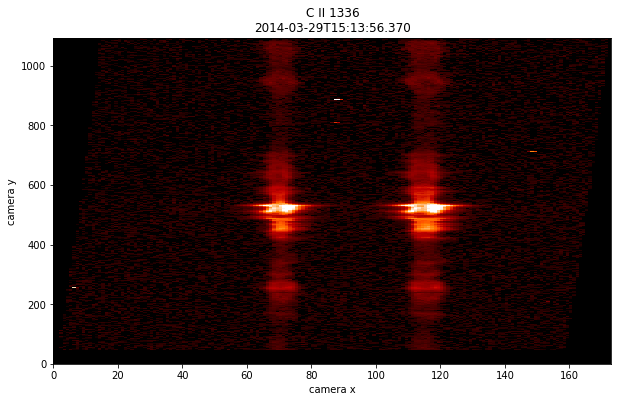

In [70]:
raster.plot( 1200 )

Luckily, we can avoid all these steps by using the OBS interface:

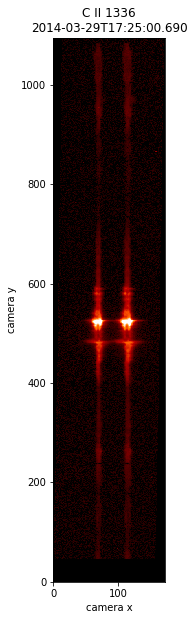

In [71]:
obs = observation("20140329_140938_3860258481")
plt.figure( figsize=(2,10))
obs.raster("C II").plot(1200)

That's it! I hope you had fun.